In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "5"
import random

import numpy as np
from elections.GaussianHelpers import cumulative_normal_dist

from elections.Candidate import Candidate
from ExperimentConfig import ExperimentConfig
from Experiment import Experiment
from CombinedExperiment import CombinedExperiment
from typing import List
from elections.PopulationGroup import Independents
from elections.Ideology import Ideology
from elections.HeadToHeadElection import HeadToHeadElection
from Experiment import RaceResult
from joblib import Parallel, delayed
from elections.GaussianHelpers import cumulative_normal_dist


def compute_SUE(election_process: str, cv: float, flexibility: float, n_voters: int, n_races: int):
    c = ExperimentConfig("v5",
                         election_process,
                         equal_pct_bins=False,
                         candidate_variance=cv,
                         ideology_flexibility = flexibility,
                         sampling_voters=n_voters,
                         model_path=f"exp/v5/{election_process}")


    x = Experiment(c)
    rr = x.run_strategic_races_par(n_races)
    sue = CombinedExperiment.compute_SUE(rr)
    count_of_ties = 0
    for r in rr:
        if r.condorcet_tie:
            count_of_ties += 1
    ties = ""
    if election_process == "H2H":
        ties = "%6.2f" % (100 * count_of_ties / len(rr))


    print("%-10s flex %.2f cv %.2f SUE % 6.3f %s" % (election_process, flexibility, cv, sue, ties))

    return sue

def make_plot_data(candidate_variance: float, n_voters: int, n_races: int):
    flexibility = np.arange(0, 1.01, .1)
    plot_data = []
    processes  = ["H2H", "IRV"]
    print("computing processes")
    for process in processes:
           sue = [compute_SUE(process, candidate_variance, f, n_voters, n_races) for f in flexibility]
           plot_data.append((flexibility, sue))

    return plot_data

In [12]:
import matplotlib.pyplot as plt
def make_line_plot(data, title, labels,
                   xlabel: str = "Candidate Ideological Flexibility (stddev)",
                   ylabel: str = "Social Utility Efficiency"):
    n_rows = 1
    n_cols = 1
    fig, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))
    fig.suptitle(title, color="black", fontsize=22)
    fig.set_facecolor("white")

    count = 0
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    axis.tick_params(axis='x', colors="black")

    for i in range(len(data)):
        d = data[i]
        plt.plot(d[0], d[1], label =labels[i])
    plt.legend()

    axis.set_xlabel(xlabel, fontsize=20)
    axis.set_ylabel(ylabel, fontsize=20)

    plt.savefig("foo.png")

In [ ]:

n_voters = 1000
n_races = 1000
plot_data_05 = make_plot_data(0.5, n_voters, n_races)
plot_data_10 = make_plot_data(1.0, n_voters, n_races)
make_line_plot(plot_data_05, "Social Utility Efficiency vs. Flexibility for Candidate Variance 0.5", ["Instant Runoff", "Condorcet-Minimax"])
make_line_plot(plot_data_10, "Social Utility Efficiency vs. Flexibility for Candidate Variance 1.0", ["Instant Runoff", "Condorcet-Minimax"])

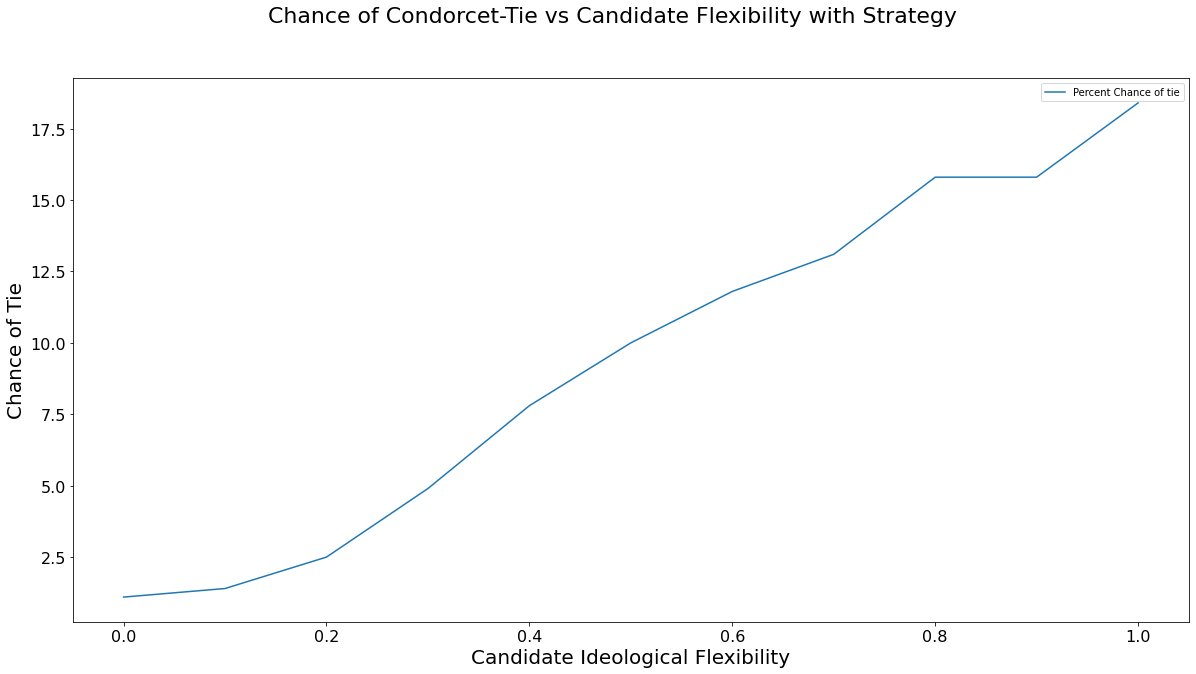

In [15]:
def make_tie_flex_plot():
    data =  \
    """H2H        flex 0.00 cv 0.50 SUE  0.991   1.10
    H2H        flex 0.10 cv 0.50 SUE  0.997   1.40
    H2H        flex 0.20 cv 0.50 SUE  1.031   2.50
    H2H        flex 0.30 cv 0.50 SUE  1.051   4.90
    H2H        flex 0.40 cv 0.50 SUE  1.069   7.80
    H2H        flex 0.50 cv 0.50 SUE  1.089  10.00
    H2H        flex 0.60 cv 0.50 SUE  1.086  11.80
    H2H        flex 0.70 cv 0.50 SUE  1.090  13.10
    H2H        flex 0.80 cv 0.50 SUE  1.095  15.80
    H2H        flex 0.90 cv 0.50 SUE  1.093  15.80
    H2H        flex 1.00 cv 0.50 SUE  1.094  18.40
    """

    lines = data.split("\n")
    lines

    t = []
    x = []
    for l in lines:
        f = l.split()
        if len(f) >= 8:
            t.append(float(f[7]))
            x.append(float(f[2]))


    make_line_plot([[x, t]],
                   "Chance of Condorcet-Tie vs Candidate Flexibility with Strategy",
                   ["Percent Chance of tie"],
                   "Candidate Ideological Flexibility",
                   "Chance of Tie"
                   )
make_tie_flex_plot()

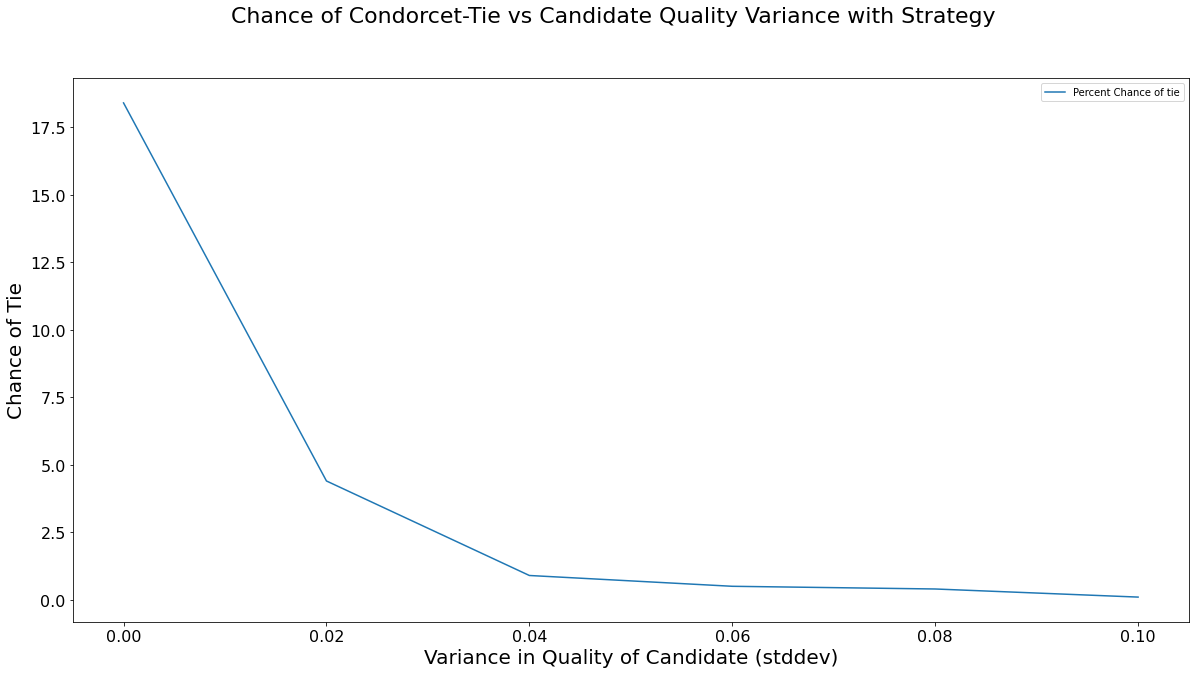

In [19]:
def make_tie_qv_plot():
    data = """
0.00  18.40
0.02  4.40
0.04  0.90
0.06  0.50
0.08  0.40
0.10  0.10
    """
    lines = data.split("\n")
    t = []
    x = []
    for l in lines:
        f = l.split()
        if len(f) >= 2:
            t.append(float(f[1]))
            x.append(float(f[0]))


    make_line_plot([[x, t]],
                   "Chance of Condorcet-Tie vs Candidate Quality Variance with Strategy",
                   ["Percent Chance of tie"],
                   "Variance in Quality of Candidate (stddev)",
                   "Chance of Tie"
                   )

make_tie_qv_plot()